# CycleGAN
Original DCGAN Code & visualizations largely from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [14]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Hyperparams

In [15]:
datarootX = "data/PetImagesSmall/Cat/"
datarootY = "data/PetImagesSmall/Dog/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 1

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

## Data Prep

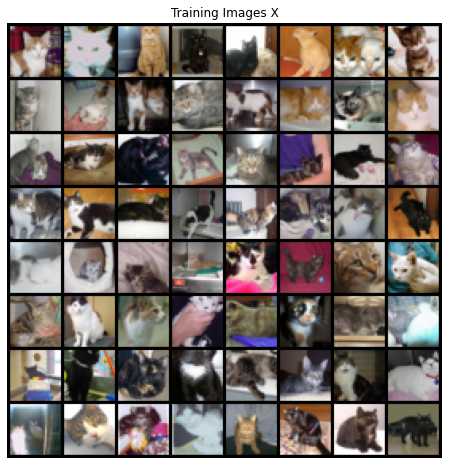

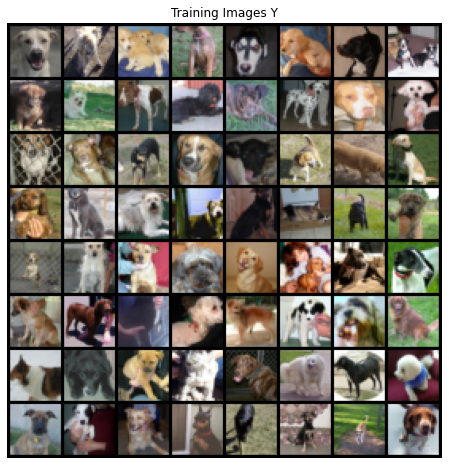

In [16]:
# Create the dataset
datasetX = dset.ImageFolder(root=datarootX,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


datasetY = dset.ImageFolder(root=datarootY,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


# Create the dataloader
dataloaderX = torch.utils.data.DataLoader(datasetX, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

dataloaderY = torch.utils.data.DataLoader(datasetY, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images for X
real_batch = next(iter(dataloaderX))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images X")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot some training images for Y
real_batch = next(iter(dataloaderY))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images Y")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Model

In [17]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [18]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            #First, do convolutions
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.ReLU(True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.ReLU(True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.ReLU(True),
#             # state size. (ndf*4) x 4 x 4
#             nn.Conv2d(ndf * 4, ndf * 4, 4, 1, 0, bias=False),
# #             nn.Sigmoid(),
#             nn.BatchNorm2d(ndf * 4),
#             nn.ReLU(True),
            
            
#             # Then, do transpose convolutions
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (nc) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

In [19]:
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

netF = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netF = nn.DataParallel(netF, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netF.apply(weights_init)

# Print the model
print(netF)

Generator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Co

In [20]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [21]:
# Create the Discriminator
netDX = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netDX = nn.DataParallel(netDX, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netDX.apply(weights_init)

# Print the model
print(netDX)

# Create the Discriminator
netDY = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netDY = nn.DataParallel(netDY, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netDY.apply(weights_init)

# Print the model
print(netDY)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (

In [22]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_X = next(iter(dataloaderX))[0].to(device)
fixed_Y = next(iter(dataloaderY))[0].to(device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerDX = optim.Adam(netDX.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerDY = optim.Adam(netDY.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerF = optim.Adam(netF.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

In [23]:

# Lists to keep track of progress
img_list_X = []
img_list_Y = []
G_losses = []
F_losses = []
DX_losses = []
DY_losses = []
iters = 0

l1_loss = nn.L1Loss()

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, dataX in enumerate(dataloaderX, 0):
        dataY = next(iter(dataloaderY))

        ############################
        # (1.1) Update DX network: maximize log(D(x)) + log(1 - D(F(z)))
        ###########################
        ## Train DX with all-real batch
        netDX.zero_grad()
        # Format batch
        real_cpu_X = dataX[0].to(device)
        b_size_X = real_cpu_X.size(0)
        label_X = torch.full((b_size_X,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through DX
        output = netDX(real_cpu_X).view(-1)
        # Calculate loss on all-real batch
        errDX_real = criterion(output, label_X)
        # Calculate gradients for D in backward pass
        errDX_real.backward()
        DX_x = output.mean().item()
        
        
        ## Train DX with all-fake batch (from Y -> X)
        # Generate fake image batch with F
        
        real_cpu_Y = dataY[0].to(device)
        b_size_Y = real_cpu_Y.size(0)
        fake_X = netF(real_cpu_Y)
        label_Y = torch.full((b_size_Y,), fake_label, dtype=torch.float, device=device)
        # Classify all fake batch with DX
        output = netDX(fake_X.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errDX_fake = criterion(output, label_Y)
        # Calculate the gradients for this batch
        errDX_fake.backward()
        DX_F_z1 = output.mean().item()
        
        
        # Add the gradients from the all-real and all-fake batches
        errDX = errDX_real + errDX_fake
        # Update DX
        optimizerDX.step()
        
        ############################
        # (1.2) Update DY network: maximize log(D(x)) + log(1 - D(F(z)))
        ###########################
        ## Train DY with all-real batch
        netDY.zero_grad()
        label_Y.fill_(real_label)
        # Forward pass real batch through DY
        output = netDY(real_cpu_Y).view(-1)
        # Calculate loss on all-real batch
        errDY_real = criterion(output, label_Y)
        # Calculate gradients for D in backward pass
        errDY_real.backward()
        DY_x = output.mean().item()
        
        
        ## Train DY with all-fake batch (from X -> Y)
        # Generate fake image batch with G
        
        fake_Y = netG(real_cpu_X)
        label_X.fill_(fake_label)
        # Classify all fake batch with DY
        output = netDY(fake_Y.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errDY_fake = criterion(output, label_X)
        # Calculate the gradients for this batch
        errDY_fake.backward()
        DY_G_z1 = output.mean().item()
        
        
        # Add the gradients from the all-real and all-fake batches
        errDY = errDY_real + errDY_fake
        # Update DY
        optimizerDY.step()
        

        ############################
        # (2.1) Update G network: maximize log(DY(G(z))) + L_Cyc(G, F)
        ###########################

        netG.zero_grad()
        label_X.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netDY(fake_Y).view(-1)
        
        #Now, update according to cycle consistency loss
        reconstructed_X = netF(fake_Y)
        
        errG_recon = l1_loss(reconstructed_X, real_cpu_X)
        
        # identity loss. Helps in practice.
        errG_id = l1_loss(netG(real_cpu_Y), real_cpu_Y)
        
        
        # Calculate G's loss based on this output
        errG = criterion(output, label_X) + 5 * errG_id + 10 * errG_recon # TODO maybe tune?
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        
        
        ############################
        # (2.2) Update F network: maximize log(DX(F(z))) + L_Cyc(F, G)
        ###########################

        netF.zero_grad()
        label_Y.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netDX(fake_X).view(-1)
        
        #Now, update according to cycle consistency loss
        reconstructed_Y = netG(fake_X)
        
        errF_recon = l1_loss(reconstructed_Y, real_cpu_Y)
        
        # identity loss. Helps in practice.
        errF_id = l1_loss(netF(real_cpu_X), real_cpu_X)
        
        
        # Calculate F's loss based on this output
        errF = criterion(output, label_Y) + 5 * errF_id + 10 * errF_recon # TODO maybe tune?
        # Calculate gradients for G
        errF.backward()
        D_F_z2 = output.mean().item()
        # Update F
        optimizerF.step()
        

        # Output training stats
        if i % 1 == 0:
            print('[%d/%d][%d/%d]\tLoss_DX: %.4f\tLoss_DY: %.4f\tLoss_G: %.4f\tLoss_F: %.4f'
                  % (epoch, num_epochs, i, len(dataloaderX),
                     errDX.item(), errDY.item(), errG.item(), errF.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        F_losses.append(errF.item())
        DX_losses.append(errDX.item())
        DY_losses.append(errDY.item())

        # Check how the generators are doing by saving F's, G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloaderX)-1)):
            with torch.no_grad():
                fake = netG(fixed_X).detach().cpu()
            img_list_X.append(vutils.make_grid(fake, padding=2, normalize=True))
            
            with torch.no_grad():
                fake = netF(fixed_Y).detach().cpu()
            img_list_Y.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/1][0/32]	Loss_DX: 1.5444	Loss_DY: 1.2362	Loss_G: 8.0193	Loss_F: 7.6922
[0/1][1/32]	Loss_DX: 1.4769	Loss_DY: 1.2962	Loss_G: 7.6771	Loss_F: 7.4526
[0/1][2/32]	Loss_DX: 1.4277	Loss_DY: 1.4224	Loss_G: 7.5990	Loss_F: 7.5091
[0/1][3/32]	Loss_DX: 1.3874	Loss_DY: 1.3633	Loss_G: 7.7176	Loss_F: 7.5319
[0/1][4/32]	Loss_DX: 1.4099	Loss_DY: 1.3163	Loss_G: 7.6962	Loss_F: 7.6301
[0/1][5/32]	Loss_DX: 1.3976	Loss_DY: 1.3037	Loss_G: 7.7739	Loss_F: 7.6132
[0/1][6/32]	Loss_DX: 1.3670	Loss_DY: 1.1884	Loss_G: 7.9265	Loss_F: 7.6673
[0/1][7/32]	Loss_DX: 1.4950	Loss_DY: 1.1170	Loss_G: 7.8024	Loss_F: 7.5585
[0/1][8/32]	Loss_DX: 1.4524	Loss_DY: 1.1145	Loss_G: 8.0200	Loss_F: 7.6233
[0/1][9/32]	Loss_DX: 1.4634	Loss_DY: 1.1237	Loss_G: 7.9614	Loss_F: 7.6834
[0/1][10/32]	Loss_DX: 1.3013	Loss_DY: 1.0982	Loss_G: 8.0003	Loss_F: 7.8470
[0/1][11/32]	Loss_DX: 1.2309	Loss_DY: 1.1330	Loss_G: 7.9565	Loss_F: 7.8317
[0/1][12/32]	Loss_DX: 1.2148	Loss_DY: 1.0802	Loss_G: 8.0007	Loss_F: 7.8064
[0/1][13/

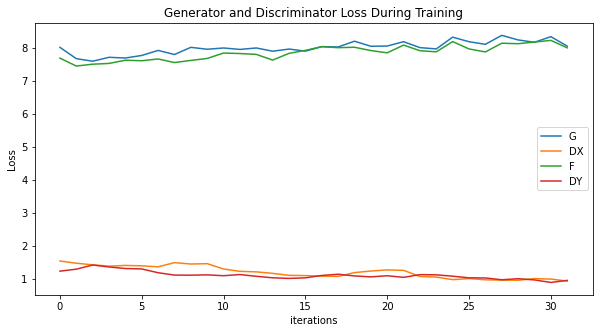

In [24]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(DX_losses,label="DX")
plt.plot(F_losses,label="F")
plt.plot(DY_losses,label="DY")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Visualize Generated Images During and After Training

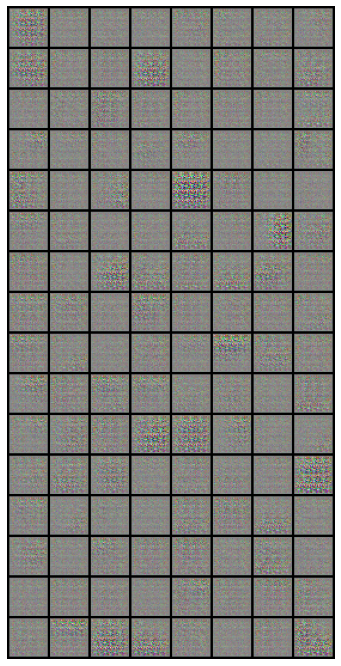

In [12]:
#%%capture
fig = plt.figure(figsize=(12,12))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list_X]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

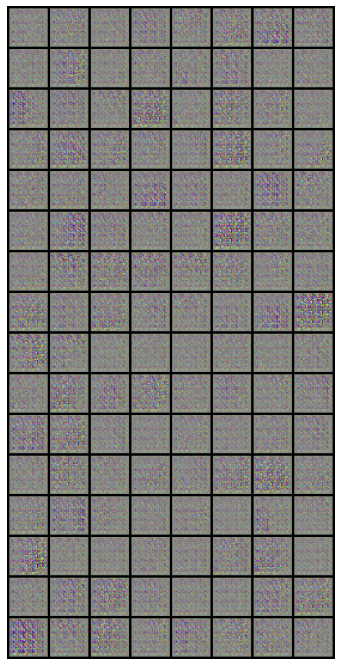

In [13]:
#%%capture
fig = plt.figure(figsize=(12,12))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list_Y]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())